In [2]:
import os
import re
import sqlite3

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## 1) Database connection using sqlite 3

In [32]:
db_path = 'database.sqlite'
con = sqlite3.connect(db_path)

### 1a) test db connection with a simple sql statement
**NOTE**: used string formatting to save potential typing later on

In [21]:
# base sql string
sql_base_select = 'SELECT {} FROM {};'

# format sql string
sql = sql_base_select.format('*', 'league')

# run select statement and show results
leagues = pd.read_sql(sql, con)
leagues.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [55]:
# how many leagues exists in db and which leagues are they
print(leagues['name'].nunique())
list(leagues['name'].unique()) # cast to list for "prettier" formatting than pd.Series object

11


['Belgium Jupiler League',
 'England Premier League',
 'France Ligue 1',
 'Germany 1. Bundesliga',
 'Italy Serie A',
 'Netherlands Eredivisie',
 'Poland Ekstraklasa',
 'Portugal Liga ZON Sagres',
 'Scotland Premier League',
 'Spain LIGA BBVA',
 'Switzerland Super League']

### 1b-1) using a **subquery** to *only* select premier league matches
**NOTE**: this avoids needing to find the league id before running the query, you just need to know a *unique* component of the league name which we can figure out from the list we printed above

In [10]:
sql = '''
    SELECT * FROM match
    WHERE league_id = (
        SELECT id from league
        WHERE name LIKE "%England%"
    );
'''

df = pd.read_sql(sql, con)
print('shape', df.shape)
df.head()

shape (3040, 115)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


### 1b-2) using a **join** to *only* select premier league matches
**NOTE**: same *rows* as above, just extra columns due to using a *different* method

**NOTE**: we could limit the columns to be the same as the subquery result if required

In [11]:
sql = '''
    SELECT * FROM match AS m
    JOIN League AS l
        ON m.league_id = l.id
    JOIN Country AS c
        ON m.country_id = c.id
    WHERE c.name = "England";
'''

df = pd.read_sql(sql, con)
print('shape', df.shape)
df.head()

shape (3040, 120)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBD,GBA,BSH,BSD,BSA,id,country_id,name,id,name
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,4.75,10.0,1.29,4.50,11.00,1729,1729,England Premier League,1729,England
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,5.50,13.0,1.22,5.00,13.00,1729,1729,England Premier League,1729,England
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,3.40,1.7,4.50,3.40,1.73,1729,1729,England Premier League,1729,England
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.25,4.0,1.91,3.25,3.80,1729,1729,England Premier League,1729,England
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.25,4.0,1.91,3.30,3.75,1729,1729,England Premier League,1729,England


In [13]:
df = pd.read_sql('SELECT * FROM match', con)
df.shape

(25979, 115)

## 2) how do team attributes and match stats vary across leagues/countries
The "Team" and "Team_attributes" tables do not have a direct link to country, we will create an augmented "Team" table that has a column for *league id* by creating a **view** this allows us to link teams to leagues **without** having to go through the **match** table

In [35]:
sql = '''
    CREATE VIEW IF NOT EXISTS Team_Augmented AS
        SELECT DISTINCT l.id AS league_id, t.*
        FROM Match AS m
        JOIN League AS l
            ON m.league_id = l.id
        JOIN Team AS t
            ON m.home_team_api_id = t.team_api_id;
'''

con.execute(sql)
con.commit()

In [36]:
df = pd.read_sql('SELECT * FROM Team_Augmented', con)
df.head()

,league_id,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,1,9987,673.0,KRC Genk,GEN
1,1,3,10000,15005.0,SV Zulte-Waregem,ZUL
2,1,5,9984,1750.0,KSV Cercle Brugge,CEB
3,1,7,9991,674.0,KAA Gent,GEN
4,1,9,7947,NaN,FCV Dender EH,DEN


### 2a) Build-up play speed

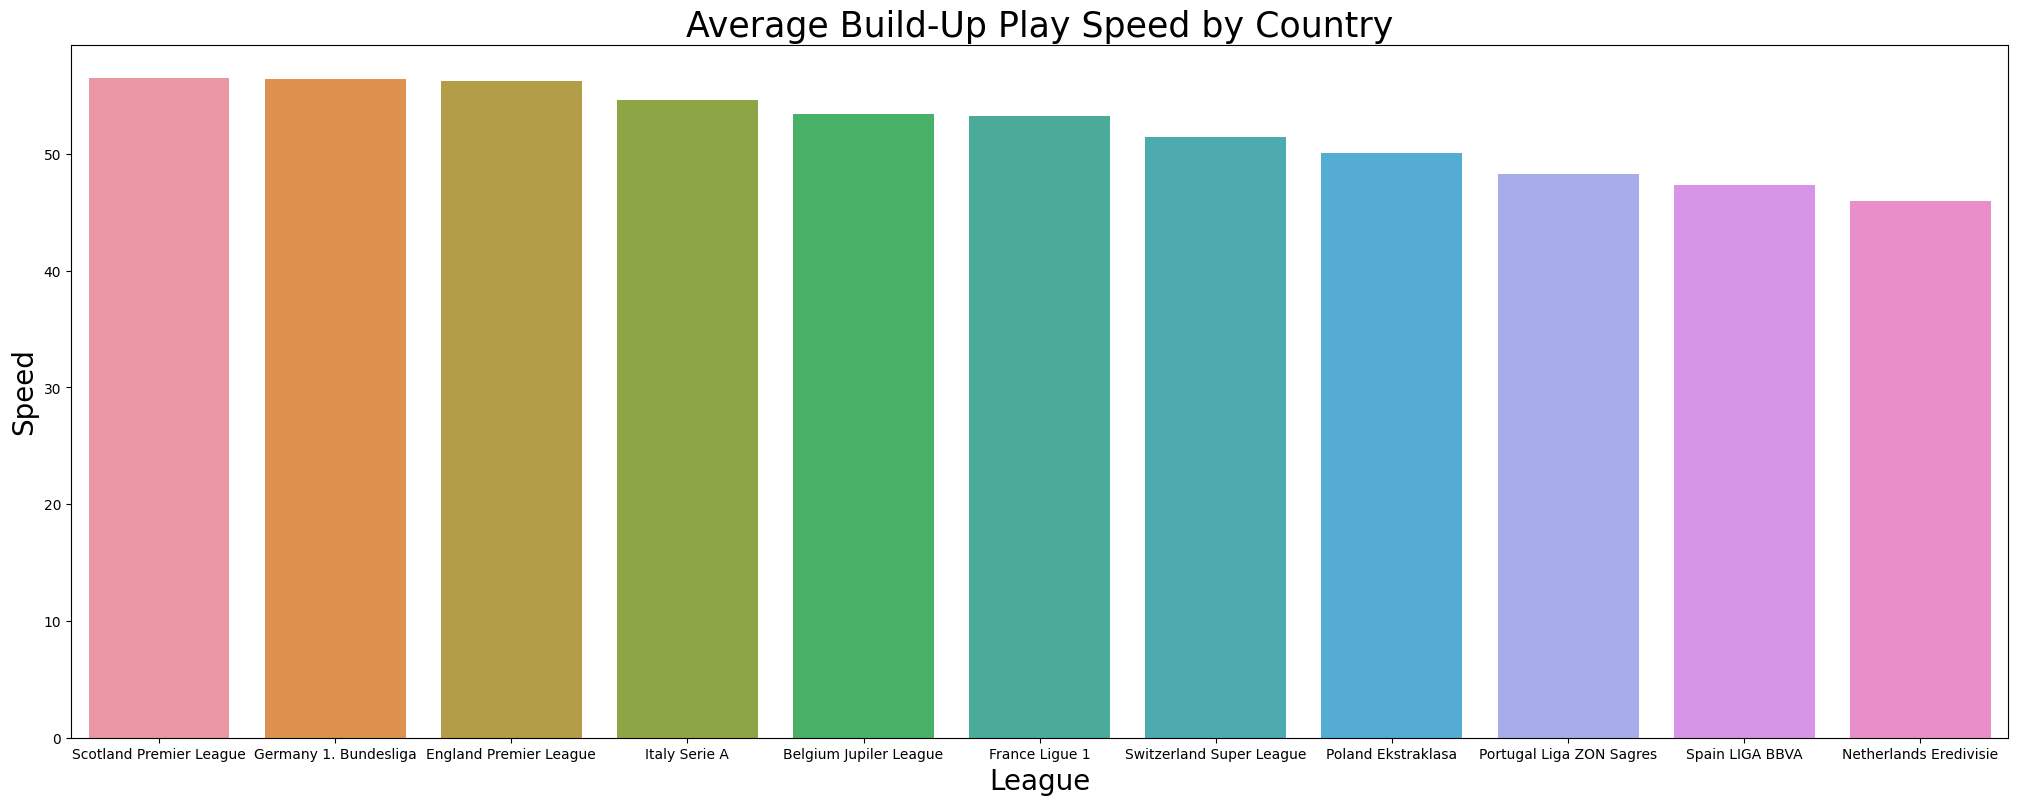

In [69]:
sql = '''
    SELECT l.name, AVG(buildUpPlaySpeed) AS avg_build_up_play_speed
    FROM Team_Attributes AS tat
    JOIN Team_Augmented AS tau
        ON tat.team_api_id = tau.team_api_id
    JOIN league AS l
        ON tau.league_id = l.id
    GROUP BY league_id
    ORDER BY avg_build_up_play_speed DESC;
'''

df = pd.read_sql(sql, con)

fig = plt.figure(figsize=(25,9))
sns.barplot(df, x='name', y='avg_build_up_play_speed')
plt.title('Average Build-Up Play Speed by Country', fontsize=25)
plt.ylabel('Speed', fontsize=20)
plt.xlabel('League', fontsize=20)
plt.show()

### 2b) Goals per game over time

In [40]:
sql = '''
    SELECT l.name, AVG(buildUpPlaySpeed) AS avg_build_up_play_speed
    FROM Team_Attributes AS tat
    JOIN Team_Augmented AS tau
        ON tat.team_api_id = tau.team_api_id
    JOIN league AS l
        ON tau.league_id = l.id
    GROUP BY league_id
    ORDER BY avg_build_up_play_speed DESC;
'''

df = pd.read_sql(sql, con)

fig = plt.figure(figsize=(25,9))
sns.barplot(df, x='name', y='avg_build_up_play_speed')
plt.title('Average Build-Up Play Speed by Country', fontsize=25)
plt.ylabel('Speed', fontsize=20)
plt.xlabel('League', fontsize=20)
plt.show()

,name,"ROUND(AVG(buildUpPlaySpeed), 2)"
0,Belgium Jupiler League,53.39
1,England Premier League,56.21
2,France Ligue 1,53.21
3,Germany 1. Bundesliga,56.42
4,Italy Serie A,54.63
5,Netherlands Eredivisie,45.96
6,Poland Ekstraklasa,50.08
7,Portugal Liga ZON Sagres,48.28
8,Scotland Premier League,56.53
9,Spain LIGA BBVA,47.37


Text(0, 0.5, 'Average Goals')

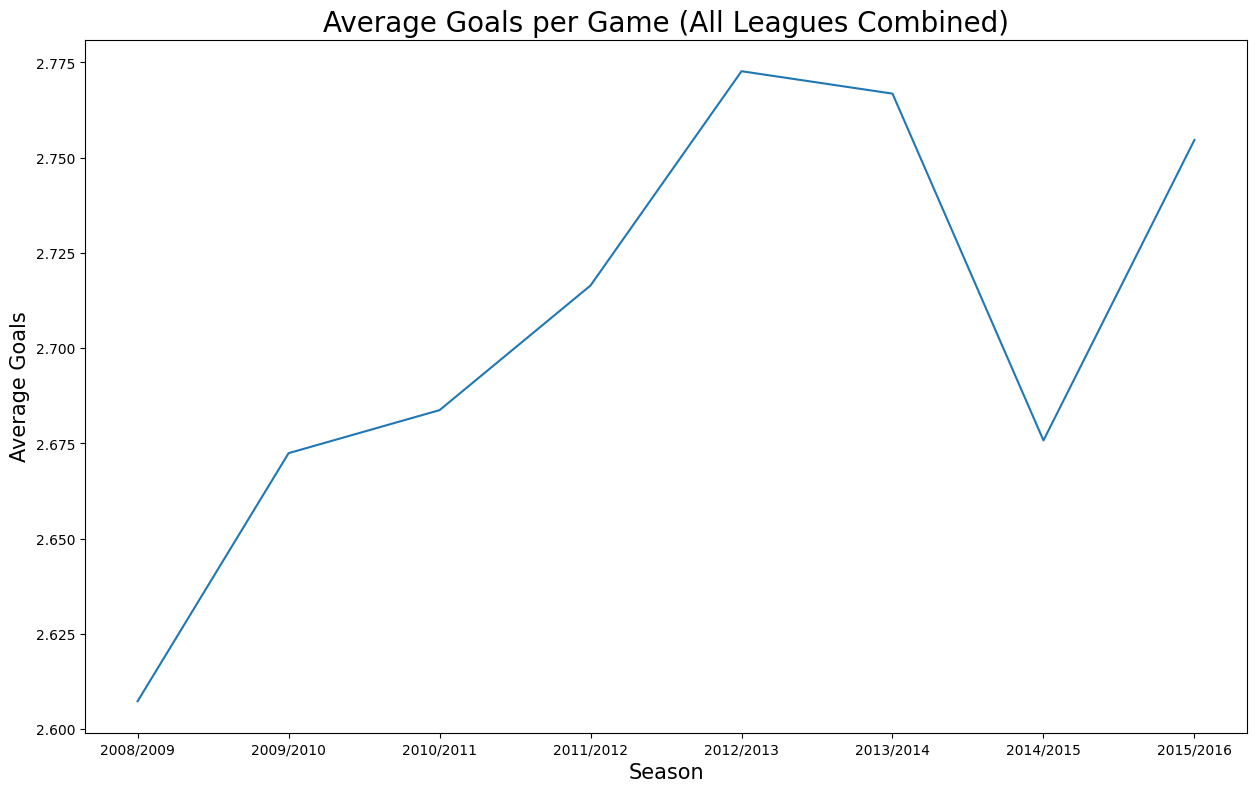

In [97]:
sql = '''
    SELECT season, AVG(m.home_team_goal + m.away_team_goal) AS average_goals
    FROM Match AS m    
    GROUP BY season;
'''

df = pd.read_sql(sql, con)

plt.figure(figsize=(15, 9))
sns.lineplot(df, x='season', y='average_goals')

plt.title('Average Goals per Game (All Leagues Combined)', fontsize=20)
plt.xlabel('Season', fontsize=15)
plt.ylabel('Average Goals', fontsize=15)

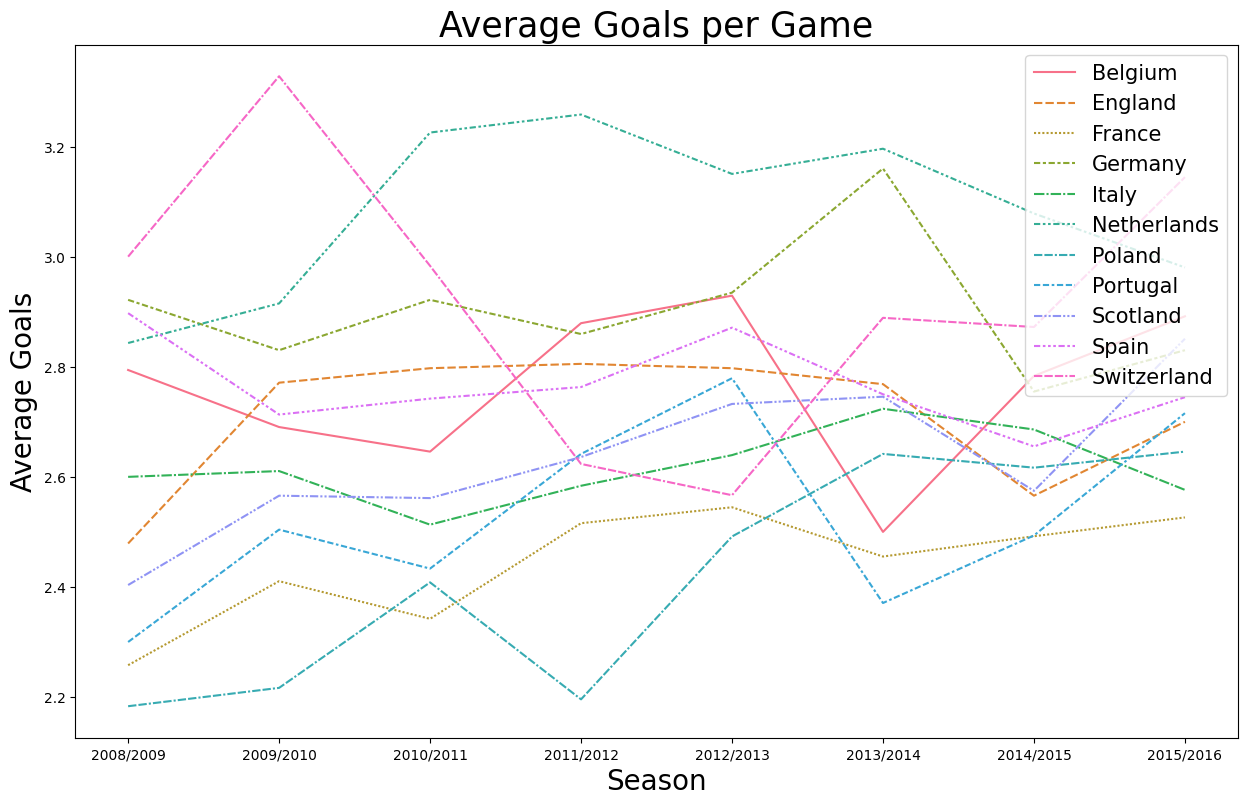

In [85]:
sql = '''
    SELECT c.name, m.season, AVG(m.home_team_goal + m.away_team_goal) AS average_goals
    FROM Match AS m
    JOIN country AS c
        ON m.country_id = c.id
    GROUP BY country_id, season;
'''

df = pd.read_sql(sql, con)
# pivot the data to allow for plotting (rows = seasons, columns = countries)
plot_df = df.pivot(columns=['name'], index='season', values='average_goals')

plt.figure(figsize=(15, 9))
sns.lineplot(plot_df)

plt.title('Average Goals per Game', fontsize=25)
plt.xlabel('Season', fontsize=20)
plt.ylabel('Average Goals', fontsize=20)
plt.legend(loc='upper right', fontsize=15)

In [100]:
sql = '''
    SELECT
        pa.player_api_id,
        ROUND(AVG(shot_power), 2) AS shot_power,
        ROUND(AVG(long_shots), 2) AS long_shots,
        weight,
        height
    FROM Player_Attributes AS pa
    JOIN Player AS p
        ON pa.player_api_id = p.player_api_id
    GROUP BY pa.player_api_id;
'''

df = pd.read_sql(sql, con)
df.corr()

,player_api_id,shot_power,long_shots,weight,height
player_api_id,1.000000,-0.149722,-0.149654,-0.164771,-0.053595
shot_power,-0.149722,1.000000,0.856473,-0.180697,-0.257442
long_shots,-0.149654,0.856473,1.000000,-0.288870,-0.363469
weight,-0.164771,-0.180697,-0.288870,1.000000,0.766626
height,-0.053595,-0.257442,-0.363469,0.766626,1.000000


## 3) Random Questions

In this section we will use SQL to pull data to answer some questions

### 3a) How well do the odds predict the results?
    1. How well do odds predict the final result (i.e. win, lose or draw)
    2. Are higher odds spreads correlated with a higher probability of a given result?
    3. Do odds spreads correlate with goal difference?

#### Add a column to the match table called "result" which will store the final result. Store the result as a view
"home" = home team wins, "away" = away team wins, "draw" = draw

In [211]:
sql = '''
    CREATE VIEW IF NOT EXISTS Match_Augmented AS
    SELECT
        *,
        CASE
        WHEN home_team_goal > away_team_goal THEN "home"
        WHEN home_team_goal < away_team_goal THEN "away"
        ELSE
            "draw"        
        END result,
        (home_team_goal + away_team_goal) AS total_goals,
        ABS(home_team_goal - away_team_goal) AS goal_difference
    FROM match;
'''

con.execute(sql)
con.commit()

sql = 'SELECT * FROM Match_Augmented'
df = pd.read_sql(sql, con)
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,result,total_goals,goal_difference
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.50,1.78,3.25,4.00,1.73,3.40,4.20,draw,2,0
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,1.85,3.25,3.75,1.91,3.25,3.60,draw,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.65,2.50,3.20,2.50,2.30,3.20,2.75,away,3,3
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,6.50,1.50,3.75,5.50,1.44,3.75,6.50,home,5,5
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.65,4.50,3.50,1.65,4.75,3.30,1.67,away,4,2


#### Out of interest, how often does each result occur?

In [115]:
# pandas version
print('raw counts')
print(df['result'].value_counts())
print('---')
print('percentage')
print(df['result'].value_counts()/df.shape[0])

raw counts
result
home    11917
away     7466
draw     6596
Name: count, dtype: int64
---
percentage
result
home    0.458717
away    0.287386
draw    0.253897
Name: count, dtype: float64


In [153]:
# sql version
# NOTE: here we NEED a subquery because we are using the column created by "SELECT" for our "GROUP BY" operation ...
#       ... without the subquery, that column doesn't exist at the time of execution of the "GROUP BY" statement ...
#       ... we could also just use the view we created (see cell below)

# NOTE: We multiply by 1.0 to ensure floating point division


sql = '''
    SELECT
        result,
        COUNT(result) AS counts,
        1.0*COUNT(result)/(SELECT COUNT(*) FROM match) AS percentage
    FROM
    (
        SELECT
            CASE
                WHEN home_team_goal > away_team_goal THEN "home"
                WHEN home_team_goal < away_team_goal THEN "away"
                ELSE
                    "draw"
            END result
        FROM match
    )
    GROUP BY result
    ORDER BY result DESC;
'''

df = pd.read_sql(sql, con)

print('percentage')
print(df)

percentage
  result  counts  percentage
0   home   11917    0.458717
1   draw    6596    0.253897
2   away    7466    0.287386


In [212]:
# sql version using the view we created
sql = '''
    SELECT
        result,        
        COUNT(result) AS counts,
        1.0*COUNT(result)/(SELECT COUNT(*) FROM match) AS percentage
    FROM
    match_augmented
    GROUP BY result
    ORDER BY result DESC;
'''

df = pd.read_sql(sql, con)

print('percentage')
print(df)

percentage
  result  counts  percentage
0   home   11917    0.458717
1   draw    6596    0.253897
2   away    7466    0.287386


#### generate a list of bookmakers
we'll use this to **programatically** write some sql instead of typing out a bunch of bookmakers by hand

In [198]:
sql = '''
    SELECT * FROM match_augmented LIMIT 1;
'''

df = pd.read_sql(sql, con)

# the columns that end with "H" represent the odds of the home team winning
# we can use these to get a list of all of the bookmakers
[col[:-1] for col in df.columns if col[-1]=='H']

['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']

In [181]:
bookmakers = [
    'B365',
    'BW',
    'IW',
    'LB',
    #'PS', # ALL values in the PS columns are null
    'WH',
    'SJ',
    'VC',
    'GB',
    'BS'
]

In [185]:
def write_sql_avg(column):
    return '(' + ' + '.join([bookmaker + column for bookmaker in bookmakers]) + ') / ' + str(len(bookmakers)) + f' AS avg_{column.lower()}_odds'

In [186]:
write_sql_avg('H')

'(B365H + BWH + IWH + LBH + WHH + SJH + VCH + GBH + BSH) / 9 AS avg_h_odds'

In [217]:
sql = 'SELECT result, goal_difference, ' + ','.join([write_sql_avg('H'), write_sql_avg('D'), write_sql_avg('A')]) + ' FROM match_augmented;'
#print(sql)

df = pd.read_sql(sql, con)
df['odds_spread'] = abs(df['avg_h_odds'] - df['avg_a_odds'])
df.head()

,result,goal_difference,avg_h_odds,avg_d_odds,avg_a_odds,odds_spread
0,draw,0,1.765556,3.322222,4.164444,2.398889
1,draw,0,1.898889,3.250000,3.616667,1.717778
2,away,3,2.462222,3.233333,2.544444,0.082222
3,home,5,1.438889,3.805556,6.533333,5.094444
4,away,2,4.494444,3.422222,1.674444,2.820000


#### how many rows have null values?

In [202]:
df.isna().sum()

result            0
avg_h_odds    11939
avg_d_odds    11939
avg_a_odds    11939
dtype: int64

In [219]:
df[['goal_difference', 'odds_spread']].corr()

,goal_difference,odds_spread
goal_difference,1.000000,0.244565
odds_spread,0.244565,1.000000


In [31]:
# close db connection
con.close()